In [1]:
# !pip install torchaudio pythainlp

In [2]:
from functools import partial
import pandas as pd
import numpy as np
from datasets import (load_dataset, load_from_disk)
from transformers import (
    Wav2Vec2CTCTokenizer, 
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    TrainingArguments
,
    Trainer,
)
import torchaudio
import torch
import re
import json
import os
from pythainlp.tokenize import word_tokenize, syllable_tokenize
from datasets import Dataset, Audio

In [3]:
audio_path = "../creolese-audio-dataset/finetune_eligible"
transcription_path = "../creolese-audio-dataset/finetune_eligible/transcripts.json"

# Load transcripts JSON
with open(transcription_path, 'r') as f:
    transcripts = json.load(f)

# Create a list of dicts pairing audio files and transcripts
data = []
for item in transcripts:
    audio_file = os.path.join(audio_path, item['audio'])
    if os.path.exists(audio_file):
        print(f"Found file: {audio_file}")
        data.append({'audio': audio_file, 'text': item['text']})
    else:
        print(f"Missing file: {audio_file}")

Found file: ../creolese-audio-dataset/finetune_eligible/1a.wav
Found file: ../creolese-audio-dataset/finetune_eligible/1b.wav
Found file: ../creolese-audio-dataset/finetune_eligible/1c.wav
Found file: ../creolese-audio-dataset/finetune_eligible/1d.wav
Found file: ../creolese-audio-dataset/finetune_eligible/1e.wav
Found file: ../creolese-audio-dataset/finetune_eligible/3a.wav
Found file: ../creolese-audio-dataset/finetune_eligible/3b.wav
Found file: ../creolese-audio-dataset/finetune_eligible/2.wav
Found file: ../creolese-audio-dataset/finetune_eligible/4a.wav
Found file: ../creolese-audio-dataset/finetune_eligible/4b.wav
Found file: ../creolese-audio-dataset/finetune_eligible/4c.wav
Found file: ../creolese-audio-dataset/finetune_eligible/4d.wav
Found file: ../creolese-audio-dataset/finetune_eligible/4e.wav
Found file: ../creolese-audio-dataset/finetune_eligible/5a.wav
Found file: ../creolese-audio-dataset/finetune_eligible/5b.wav
Found file: ../creolese-audio-dataset/finetune_eligible/

In [4]:
dataset = Dataset.from_list(data)

# Cast the audio column to automatically load audio
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

dataset


Dataset({
    features: ['audio', 'text'],
    num_rows: 265
})

In [5]:
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

train_dataset
# eval_dataset

Dataset({
    features: ['audio', 'text'],
    num_rows: 212
})

In [6]:
def preprocess_data(example, tok_func = word_tokenize):
    example["text"] = ''.join(tok_func(example["text"].lower()))
    return example

train_dataset = train_dataset.map(preprocess_data)
eval_dataset = eval_dataset.map(preprocess_data)

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]

In [7]:
import re
chars_to_remove_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\']'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_remove_regex, '', batch["text"]).lower()
    return batch

train_dataset = train_dataset.map(remove_special_characters)
eval_dataset = eval_dataset.map(remove_special_characters)

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]

In [8]:
#show random sentences
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

show_random_elements(train_dataset.remove_columns(["audio"]), num_examples=20)

,text
0,nisesitii ov having somting on di waalz hii left aal di dekoreeshon aal di dekoreeting disishons tu hor wail pruvaiding di monii ov koors biikaaz ov dis kolekshon ov hors luuwisis frenz hav givin hor di repyuuteeshon ov having a gud nooz for art invesmenz bot dis iz naat wai shii baat di pikchorz wee bak den shii baat dem biikaaz shii waantid dem shii waantid somting dat woz insaid dem aaldoo shii kud naat hav sed at di taim waat it woz it woz naat piis shii doz naat fain dem piisful in di liist luking at dem filz
1,nou dat di boys ar groon op an raab iz ded luuwis haz muuvd intu a kondimooniiyom apartment in won ov turontooz nyuu waatorfront diivelopments shii iz riliivd tu naat worii about di laan or about i aivii pushing its moskuulor litl sokors intu di brikwork or di skwirils naaing deer wee intu di atik an iiting di insileeshon aaf ov di wairing or about schreenj noyzis di bilding haz a siikyuuritii sistem an di oonlii plant laif iz in paats on di silariiyom luuwis iz gladshii shiiz bin eebl tu faind an apartment big inof for hor pichors dee ar moor
2,ac oo ac otiks main tuu at yu hous shii se dii ac gaan gaan oo su iz fain lais yuu gaa sliip wit tunait lazkoo girl een non raang wid sliipin wit a fan mai gaad fors worl isyuuz ai noo rait
3,aarait soo ai red di nyuuz ai red a short stoorii so nou aim gooing tu riid om a redit poost an kanaat heer hoop dats ookee eniiweez om soo aim a torti tuu yeer oold fiimeel an aim korentlii eet monts pregnont wit our forst chaild mai hosbond taam torti faiv and ai hav bin tugedor for seven yeerz an ooveraal wii hav a greet riileeshonship dii oonlii ishyuu is mom a sikti tuu yeer oold wumon neemd lindo lindo haz aalweez bin oovorbeering di taip ov modor huu stil kaals
4,na na na na mii gu tek mi taim an kuk man mii na horii mii na horii nat at al mi na horii <unk> heloo hai gyorl hai yes gyorl ai alrait ai woz a di gyafin wid mi neebo
5,jramatik dat its jost a fyuu ekstro piipl nou ai fiil laik aim biiying gangd op on ai doont waant tu deschraay mai riileeshonship wit mai modor in laa bot ai aalsoo doont waant tu fiil aankomfortebl juuring soch an impoortont mooment waat shud ai duu
6,yuujulii biikom voyd meejiz stof laik dat rait o guwing bak tuu majik yuus an it biiying kain ov bad do moor majik dat yuu yuuz az an iitor do moor said iifeks it haz oon yor bodii prolaangd ekspoojor tuu do majik kan kaaz a porsons main an bodii tu sloolii duikee and koropt dat iz kreezii dat iz soo kreezii laik da haior levl
7,dii mahn is fo pik mii op biifoor ai gu fo bai fruuts ai gu fo bai fruuts from a neerbai kaarn went tu chorch and ai gu fo bai fruuts from a neerbai kaarn a neerbai stan dii taksii mahn noo mii from laang laang laang ii noo mii from siiyin mii bout dii plees an kopl wel taim ai gu an chravil wit ii eniiwee ai chravil wid dii mahn an ai seh luk ai gaa bai somtin bo ii se horii op kwik dii mahn goon jrop of anada set o piipl dat ii gun pik op from chorch da ii neva tel mii ii had tu gun pik op ai se arait noo problem ii gu
8,di smaal biznis byuuroo mistor shaziim eebroham hailaitid di proograms lasting impakt wii rekognaiz di putenshol ov yong onchriprinyuurs an di impoortons ov iikwiping dem wid di rait tuuls yep twenti twenti faiv gooz biiyaand pruvaiding moniterii riiwaardz tu help schuudens laanch deer biznisis it faastorz inooveeshon riiziliiyens and an onchriprinyuuriiyol mainset dat wil empouwer dem boot in di klasruum an truu out deer laivs do smaal biznis byuuroo in kolaboreeshon wid di minischrii ov ejuukeeshon riimeenz
9,yu main ekspleenin hou piipl getin fo taip in dii anounsment


<Axes: >

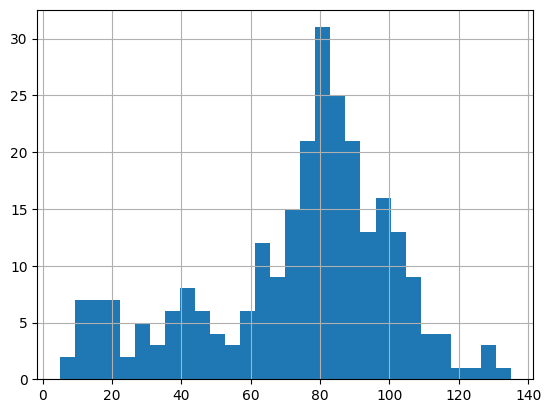

In [9]:
train_df = pd.DataFrame({'text':dataset['text']})
train_df['nb_words'] = train_df.text.map(lambda x: len(x.split()))
train_df.nb_words.hist(bins=30)

In [10]:
def create_vocabulary_from_dataset(dataset, text_col="text"):
    # Extract all unique characters from the dataset
    vocab = set()
    for item in dataset:
        vocab.update(item[text_col].lower())

    # Sort characters
    char_list = sorted(list(vocab))
    print(f"Base characters: {char_list}")

    # Create vocab dict starting from 0
    vocab_dict = {}
    for i, char in enumerate(char_list):
        vocab_dict[char] = i

    return vocab_dict

# Usage
vocab_dict = create_vocabulary_from_dataset(dataset)

Base characters: [' ', '!', "'", '(', ')', ',', '-', '.', '/', ':', '<', '>', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']


In [11]:
#make space = |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

#padding token serves as blank token
vocab_dict["[UNK]"] = len(vocab_dict)

In [12]:

vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict), vocab_dict

(40,
 {'!': 1,
  "'": 2,
  '(': 3,
  ')': 4,
  ',': 5,
  '-': 6,
  '.': 7,
  '/': 8,
  ':': 9,
  '<': 10,
  '>': 11,
  '?': 12,
  'a': 13,
  'b': 14,
  'c': 15,
  'd': 16,
  'e': 17,
  'f': 18,
  'g': 19,
  'h': 20,
  'i': 21,
  'j': 22,
  'k': 23,
  'l': 24,
  'm': 25,
  'n': 26,
  'o': 27,
  'p': 28,
  'q': 29,
  'r': 30,
  's': 31,
  't': 32,
  'u': 33,
  'v': 34,
  'w': 35,
  'y': 36,
  'z': 37,
  '|': 0,
  '[UNK]': 38,
  '[PAD]': 39})

In [13]:
# #save as json; create tokenizer for the first time and upload to hugginface hub
with open('../tokenizer_files/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)
tokenizer = Wav2Vec2CTCTokenizer("../tokenizer_files/vocab.json", 
                                 unk_token="[UNK]", 
                                 pad_token="[PAD]", 
                                 word_delimiter_token="|")

In [14]:
train_dataset[0]["text"]

'wiin godo seev dis fo leeto kaaz ai duu hav som work ai godo goo an duu om bot doon iivin doon iivin worii chros mii yuu wil risiiv yor voys noots boy ya ai duu niid tu goo duu som work biikos da hool da hool preporeeshon for koriir feer gaa mii a lidl bit biihain in mai work an ai godo kach op iz no aim no biihain bai a laat doo iz jos laik  waan or tuu lekchors dat ai mis dat ai niid tu om'

In [15]:
tokenizer(train_dataset[0]["text"])

{'input_ids': [35, 21, 21, 26, 0, 19, 27, 16, 27, 0, 31, 17, 17, 34, 0, 16, 21, 31, 0, 18, 27, 0, 24, 17, 17, 32, 27, 0, 23, 13, 13, 37, 0, 13, 21, 0, 16, 33, 33, 0, 20, 13, 34, 0, 31, 27, 25, 0, 35, 27, 30, 23, 0, 13, 21, 0, 19, 27, 16, 27, 0, 19, 27, 27, 0, 13, 26, 0, 16, 33, 33, 0, 27, 25, 0, 14, 27, 32, 0, 16, 27, 27, 26, 0, 21, 21, 34, 21, 26, 0, 16, 27, 27, 26, 0, 21, 21, 34, 21, 26, 0, 35, 27, 30, 21, 21, 0, 15, 20, 30, 27, 31, 0, 25, 21, 21, 0, 36, 33, 33, 0, 35, 21, 24, 0, 30, 21, 31, 21, 21, 34, 0, 36, 27, 30, 0, 34, 27, 36, 31, 0, 26, 27, 27, 32, 31, 0, 14, 27, 36, 0, 36, 13, 0, 13, 21, 0, 16, 33, 33, 0, 26, 21, 21, 16, 0, 32, 33, 0, 19, 27, 27, 0, 16, 33, 33, 0, 31, 27, 25, 0, 35, 27, 30, 23, 0, 14, 21, 21, 23, 27, 31, 0, 16, 13, 0, 20, 27, 27, 24, 0, 16, 13, 0, 20, 27, 27, 24, 0, 28, 30, 17, 28, 27, 30, 17, 17, 31, 20, 27, 26, 0, 18, 27, 30, 0, 23, 27, 30, 21, 21, 30, 0, 18, 17, 17, 30, 0, 19, 13, 13, 0, 25, 21, 21, 0, 13, 0, 24, 21, 16, 24, 0, 14, 21, 32, 0, 14, 21, 21, 2

In [16]:
tokenizer.decode(tokenizer(train_dataset[0]["text"]).input_ids)

'win godo sev dis fo leto kaz ai du hav som work ai godo go an du om bot don ivin don ivin wori chros mi yu wil risiv yor voys nots boy ya ai du nid tu go du som work bikos da hol da hol preporeshon for korir fer ga mi a lidl bit bihain in mai work an ai godo kach op iz no aim no bihain bai a lat do iz jos laik wan or tu lekchors dat ai mis dat ai nid tu om'

# Feature Extractor TIme

In [17]:
# feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, 
#                                               sampling_rate=16000, 
#                                               padding_value=0.0, 
#                                               do_normalize=True, 
#                                               return_attention_mask=False)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [18]:

def prepare_dataset(batch, processor):
    audio = batch["audio"]

    # Get input values from audio
    input_values = processor(
        audio["array"], 
        sampling_rate=audio["sampling_rate"],
        return_tensors="pt",
        return_attention_mask=True
    ).input_values[0]

    # Get labels from text
    batch["labels"] = processor.tokenizer(batch["text"]).input_ids
    

    # Return proper format for CTC
    return {
        "input_values": input_values,
        "labels": batch["labels"]
    }


In [19]:
import librosa
import numpy as np
from datasets import Dataset

def augment_audio(audio_array, sr=16000):
    """Apply random augmentations to audio"""
    augmented_versions = []

    # Original
    augmented_versions.append(audio_array)

    # Speed change (0.9x to 1.1x speed)
    speed_factor = np.random.uniform(0.9, 1.1)
    speed_changed = librosa.effects.time_stretch(audio_array, rate=speed_factor)
    augmented_versions.append(speed_changed)

    # Pitch shift (-2 to +2 semitones)
    pitch_shift = np.random.randint(-2, 3)
    pitch_shifted = librosa.effects.pitch_shift(audio_array, sr=sr, n_steps=pitch_shift)
    augmented_versions.append(pitch_shifted)

    # Add slight noise
    noise_factor = 0.005
    noise = np.random.randn(len(audio_array)) * noise_factor
    noisy = audio_array + noise
    augmented_versions.append(noisy)

    return augmented_versions

def create_augmented_dataset(original_dataset, num_augmentations=2):
    """Create augmented dataset"""
    augmented_data = []

    for item in original_dataset:
        # Original item
        augmented_data.append(item)

        # Create augmented versions
        audio_array = item["audio"]["array"]
        for i in range(num_augmentations):
            augmented_audio = augment_audio(audio_array)[1 + i]  # Skip original

            augmented_item = {
                "audio": {
                    "array": augmented_audio,
                    "sampling_rate": item["audio"]["sampling_rate"]
                },
                "text": item["text"]  # Same text
            }
            augmented_data.append(augmented_item)

    return augmented_data

# Create augmented dataset
print("Creating augmented dataset...")
augmented_train_data = create_augmented_dataset(train_dataset, num_augmentations=2)
augmented_train_dataset = Dataset.from_list(augmented_train_data)

# Apply preprocessing
augmented_train_dataset = augmented_train_dataset.map(
    prepare_dataset, 
    remove_columns=train_dataset.column_names,
    num_proc=1, 
    fn_kwargs={"processor": processor}
)

print(f"Original training size: {len(train_dataset)}")
print(f"Augmented training size: {len(augmented_train_dataset)}")

Creating augmented dataset...


Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Original training size: 212
Augmented training size: 636


In [20]:
train_dataset = augmented_train_dataset

# Apply preprocessing to both splits
# train_dataset = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names, num_proc=4, fn_kwargs={"processor": processor})
eval_dataset = eval_dataset.map(prepare_dataset, remove_columns=eval_dataset.column_names, num_proc=4, fn_kwargs={"processor": processor})

Map (num_proc=4):   0%|          | 0/53 [00:00<?, ? examples/s]

# Data Collator Time

In [21]:


from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [22]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [23]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    # # "facebook/wav2vec2-xls-r-300m",
    attention_dropout=0.1,
    # hidden_dropout=0.1,
    # feat_proj_dropout=0.1,
    # mask_time_prob=0.05,
    # layerdrop=0.1,
    # gradient_checkpointing=True,
    ctc_loss_reduction="mean",
    ctc_zero_infinity=True,
    mask_time_prob=0.065,  # Original: 0.065 (Sec 3.1)
    mask_time_length=10,    # Original: 10 (Sec 3.1)
    gradient_checkpointing=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

/home/kris/Documents/fyp/fyp_env/lib/python3.11/site-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.wav2vec2.feature_extractor._freeze_parameters()


In [25]:
import evaluate

metric = evaluate.load("wer")
# cer_metric = evaluate.load("mer")
# mer_metric = evaluate.load("cer")


In [26]:


def compute_metrics(pred, processor=processor, metric=metric):
        pred_logits = pred.predictions
        pred_ids = np.argmax(pred_logits, axis=-1)

        pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

        pred_str = processor.batch_decode(pred_ids)
        # we do not want to group tokens when computing the metrics
        label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

        wer = metric.compute(predictions=pred_str, references=label_str)

        return {"wer": wer}

In [30]:

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../training_outputs/wav2vec2_training_output",
    group_by_length=True,
    # label_smoothing=0.1,
    # max_grad_norm=0.5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    eval_strategy="steps",
    num_train_epochs=15,
    gradient_checkpointing=True,
    fp16=torch.cuda.is_available(),
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    learning_rate=1e-4,
    warmup_steps=100,
    push_to_hub=False,
    dataloader_num_workers=4,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False
)


In [31]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=processor.feature_extractor
)


In [32]:
trainer.train(resume_from_checkpoint=True)
# trainer.train()

/home/kris/Documents/fyp/fyp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/kris/Documents/fyp/fyp_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/kris/Documents/fyp/fyp_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate cal

Step,Training Loss,Validation Loss,Wer
650,2.953600,2.944173,1.000000
700,3.013300,2.961918,1.000000
750,2.921700,2.970183,1.000000
800,2.973500,2.933332,1.000000
850,2.861200,2.889464,1.000000
900,2.934400,2.996123,1.000000
950,2.950200,2.959574,1.000000
1000,2.937800,2.980983,1.000000
1050,2.931800,2.978683,1.000000
1100,2.882900,2.918236,1.000000


/home/kris/Documents/fyp/fyp_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/kris/Documents/fyp/fyp_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/kris/Documents/fyp/fyp_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can proce

TrainOutput(global_step=4770, training_loss=2.5719888187304485, metrics={'train_runtime': 143827.9187, 'train_samples_per_second': 0.066, 'train_steps_per_second': 0.033, 'total_flos': 2.377205293313482e+18, 'train_loss': 2.5719888187304485, 'epoch': 15.0})

In [33]:
# kchase9/wav2vec2-asr-creolese
from huggingface_hub import notebook_login
notebook_login()

In [34]:
# trainer.push_to_hub("kchase9/whisper-creolese-tiny")

model.push_to_hub(
        "kchase9/wav2vec2-creolese-finetuned",
        create_pr=False,
        private=False
)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kchase9/wav2vec2-creolese-finetuned/commit/af13474036991067306ecf4368515385d49ee7c7', commit_message='Upload Wav2Vec2ForCTC', commit_description='', oid='af13474036991067306ecf4368515385d49ee7c7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kchase9/wav2vec2-creolese-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='kchase9/wav2vec2-creolese-finetuned'), pr_revision=None, pr_num=None)

In [38]:
# Post train, get sample dataset
audio_path = "../creolese-audio-dataset/finetune_eligible"
transcription_path = "../creolese-audio-dataset/finetune_eligible/transcripts.json"

# Load transcripts JSON
with open(transcription_path, 'r') as f:
    transcripts = json.load(f)

# Create a list of dicts pairing audio files and transcripts
data = []
for item in transcripts:
    audio_file = os.path.join(audio_path, item['audio'])
    if os.path.exists(audio_file):
        # print(f"Found file: {audio_file}")
        data.append({'audio': audio_file, 'text': item['text']})
    else:
        print(f"Missing file: {audio_file}")

dataset = Dataset.from_list(data)

# Cast the audio column to automatically load audio
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
final_eval_dataset = split_dataset["test"]

# final_eval_dataset = final_eval_dataset.map(prepare_dataset, remove_columns=dataset.column_names, num_proc=1)
print(final_eval_dataset)


# Model Evaluation - Calculate WER, MER, and CER
import evaluate
import torch
from tqdm.auto import tqdm
from transformers import pipeline
import pandas as pd
import json

# Load evaluation metrics
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

def calculate_mer(predictions, references):
    """Calculate Match Error Rate (MER)"""
    total_matches = 0
    total_words = 0
    
    for pred, ref in zip(predictions, references):
        pred_words = pred.split()
        ref_words = ref.split()
        
        # Count exact matches
        matches = sum(1 for p, r in zip(pred_words, ref_words) if p == r)
        total_matches += matches
        total_words += max(len(pred_words), len(ref_words))
    
    mer = 1 - (total_matches / total_words) if total_words > 0 else 0
    return mer

def evaluate_model_fast(model, processor, eval_dataset, device="cpu"):
    """Evaluate the model using eval dataset directly"""
    model.eval()
    predictions = []
    references = []
    
    print(f"Evaluating on {len(eval_dataset)} samples...")
    pipe = pipeline(
        "automatic-speech-recognition",
        model=model,
        feature_extractor=processor.feature_extractor,
        tokenizer=processor.tokenizer,
        device=0 if device == "cuda" else -1
    )
    
    # Process eval dataset
    for i in range(len(eval_dataset)):
            
        try:
            # Get the audio data from eval_dataset
            sample = eval_dataset[i]
            
            # Use the pipeline for inference
            # result = pipe(sample['input_features'])
            # hypothesis = result["text"].strip().lower()

            audio_file_path = sample['audio']['path']
            reference = sample['text']

            # Use pipeline on the audio file
            result = pipe(audio_file_path)
            hypothesis = result["text"]
            
            # # Get reference text - decode from labels
            # labels = sample['labels']
            # # Replace -100 with pad token
            # labels = [l for l in labels if l != -100]
            # reference_text = processor.tokenizer.decode(labels, skip_special_tokens=True).strip().lower()
            
            predictions.append(hypothesis)
            references.append(reference)
            
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue
    
    print(f"\nSuccessfully processed {len(predictions)} samples")
    print("Calculating metrics...")
    
    # Calculate metrics
    wer = wer_metric.compute(predictions=predictions, references=references)
    cer = cer_metric.compute(predictions=predictions, references=references)
    mer = calculate_mer(predictions, references)
    
    return {
        "wer": wer,
        "cer": cer, 
        "mer": mer,
        "predictions": predictions,
        "references": references
    }

# Run evaluation
print("Starting evaluation...")
results = evaluate_model_fast(model, processor, final_eval_dataset, device='cpu')

Dataset({
    features: ['audio', 'text'],
    num_rows: 53
})


Device set to use cpu


Starting evaluation...
Evaluating on 53 samples...

Successfully processed 53 samples
Calculating metrics...


In [39]:
print(results['wer'])
print(results['cer'])
print(results['mer'])

1.0
1.0
1.0
